In [1]:
from datasets import build_dataset
import argparse
import opts

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import base64
from PIL import Image
import json
import textwrap

In [2]:
# Jupyter Notebook이 전달하는 인자 제거
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Jupyter 추가 인자를 제거

parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
args = parser.parse_args()

In [3]:
train_dataset = build_dataset('a2d', image_set = 'train', args = args)
text_annotations = train_dataset.text_annotations


 train sample num:  15747




In [4]:
with open('mbench_a2d/numbered_captions.json', 'r') as file:
    captions = json.load(file)

In [5]:
def mark_object_and_encode(frame, mask, text_query, vid_id, frame_idx, instance_id, color_mask=False, label_number=False):
    #마스크 색칠할지
    if color_mask == True:
        alpha = 0.1

        colored_mask = np.zeros_like(frame)
        colored_mask[mask == 1] = [255, 0, 0]
        frame[mask == 1] = (
            (1 - alpha) * frame[mask == 1] +
            alpha * colored_mask[mask == 1]
        )

    #마스크 아웃라인 그리기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, [255, 0, 0], 2)

    #instance_id 적을지
    if label_number == True:
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:  
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
            else:
                center_x, center_y = 0, 0

            font = cv2.FONT_HERSHEY_SIMPLEX
            text = str(instance_id)
            font_scale = 0.6  
            text_size = cv2.getTextSize(text, font, font_scale, 2)[0]                        
            text_x = center_x - text_size[0] // 1  # 텍스트의 가로 중심
            text_y = center_y
            # text_y = center_y + text_size[1] // 2 # 텍스트의 세로 중심
            
            # 텍스트 배경 사각형 좌표 계산
            rect_start = (text_x - 5, text_y - text_size[1] - 5) # 배경 사각형 좌상단
            # rect_end = (text_x + text_size[0] + 5, text_y + 5) 
            rect_end = (text_x + text_size[0] + 5, text_y)
            
            cv2.rectangle(frame, rect_start, rect_end, (0, 0, 0), -1)
            cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), 2)

    fig, ax = plt.subplots(figsize=(6, 10))
    ax.imshow(frame)

    text_query = "\n".join(textwrap.wrap(text_query, width=60))
    ax.text(0.5, -0.3, text_query, ha='center', va='center', fontsize=12, transform=ax.transAxes)

    plt.title(f"vid id: {vid_id}, frame id: {frame_idx}, instance id: {instance_id}")
    plt.tight_layout()
    plt.axis('off')
    plt.show()


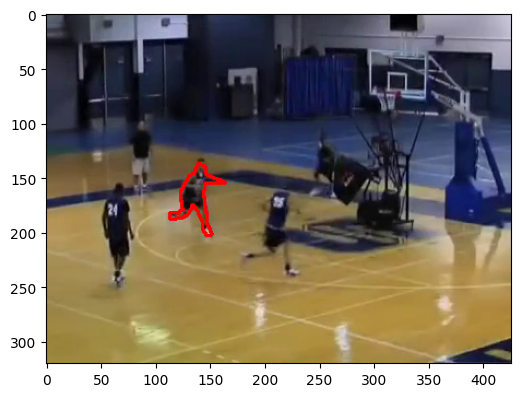

In [10]:
test_frame = train_dataset[3][0][1].permute(1, 2, 0).numpy()
test_mask = train_dataset[3][1]['masks'].numpy().astype(np.uint8).squeeze()

fig, ax = plt.subplots(figsize=(6,10))
contours, _ = cv2.findContours(test_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_frame, contours, -1, [255, 0, 0], 2)
ax.imshow(test_frame)


In [ ]:
train_dataset[0][1]['valid_indices']

{'frames_idx': tensor([ 24,  26,  29,  31, 170]),
 'valid_indices': tensor([2]),
 'labels': tensor([0]),
 'boxes': tensor([[214.,  93., 302., 147.]]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'valid': tensor([1]),
 'caption': 'the pigeon is limping',
 'orig_size': tensor([320, 568]),
 'size': tensor([320, 568]),
 'image_id': 'v_--h5fAKYurM_f_30_i_0'}

In [28]:
def checkAllCaptions(captions, dataset, text_annotations):
    vid_ids = list(captions.keys())
    first_vid_id = vid_ids[0]
    last_vid_id = vid_ids[-1]

    train_idx = 0
    last_index = max(i for i, item in enumerate(text_annotations) if item[1] == last_vid_id)
    text_query, vid_id, frame_id, instance_id = text_annotations[train_idx]

    while vid_id != first_vid_id:
        train_idx += 1
        text_query, vid_id, frame_id, instance_id = text_annotations[train_idx]

    while train_idx <= last_index:
        text_query, vid_id, frame_id, instance_id = text_annotations[train_idx]
        print(vid_id)
        train_data = dataset[train_idx] #getitem할 때마다 새로 샘플링됨
        frame_id -= 1
    
        #print(f"train idx: {train_idx}")
        frame_order = train_data[1]['frames_idx'].tolist().index(frame_id)
        valid_indices = train_data[1]['valid_indices'].item()

        assert frame_order == valid_indices, "could not find valid frame!"
        
        frame = train_data[0][frame_order, :, :, :].permute(1, 2, 0).numpy()
        mask = train_data[1]['masks'].numpy().astype(np.uint8).squeeze()

        instance_caption = captions[vid_id][str(frame_id)][str(instance_id)]
            
        if instance_caption:
            mark_object_and_encode(frame, mask, instance_caption, vid_id, frame_id, instance_id, color_mask=False, label_number=True)
        else:
            mark_object_and_encode(frame, mask, "None", vid_id, frame_id, instance_id, color_mask=False, label_number=True)

        train_idx += 1

-7AwCPcgrzA


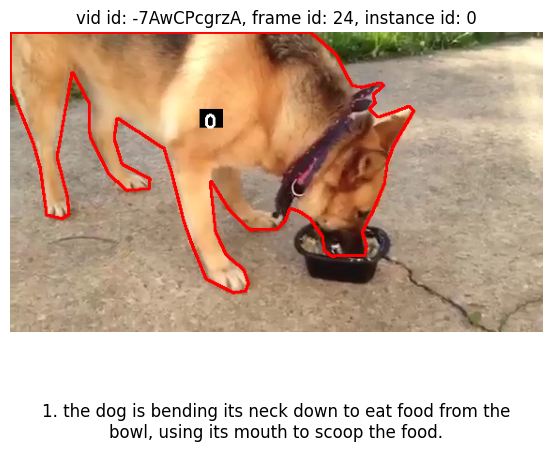

-7AwCPcgrzA


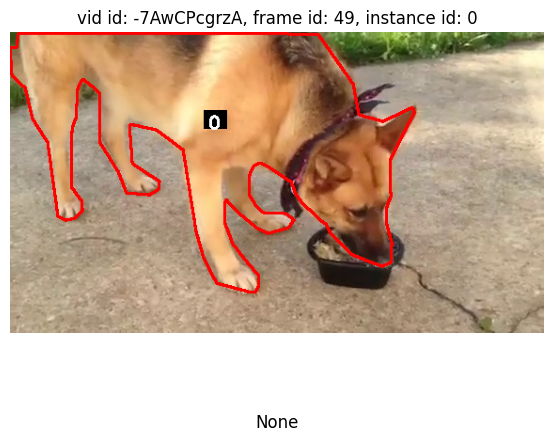

-7AwCPcgrzA


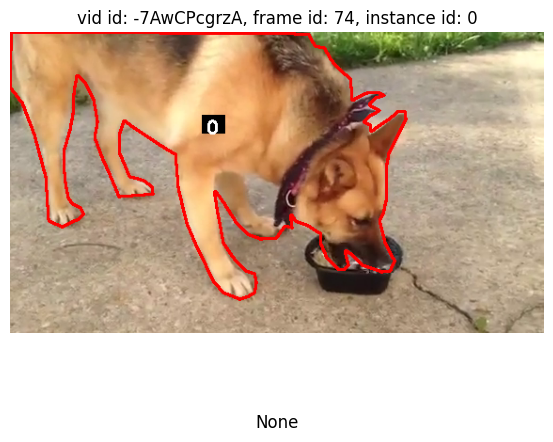

-7AwCPcgrzA


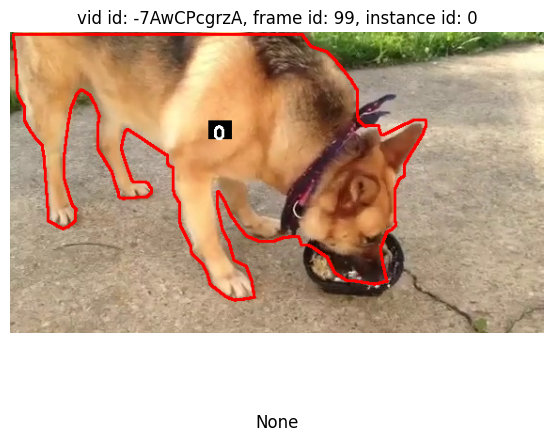

-7AwCPcgrzA


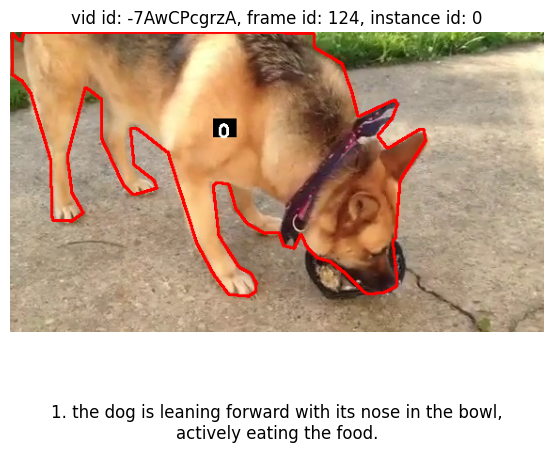

-7e9bizUyHg


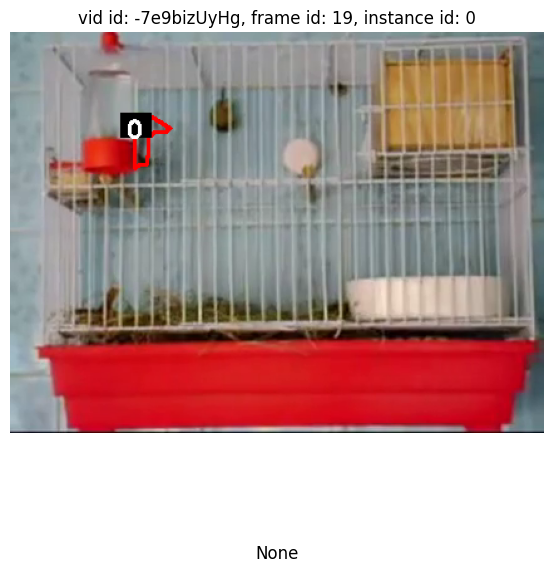

-7e9bizUyHg


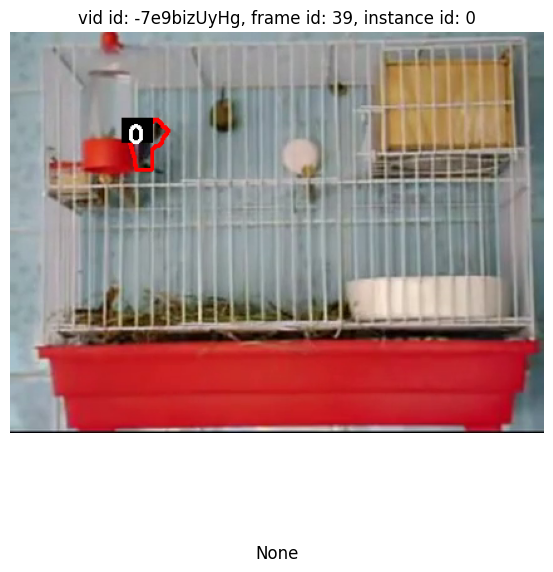

-7e9bizUyHg


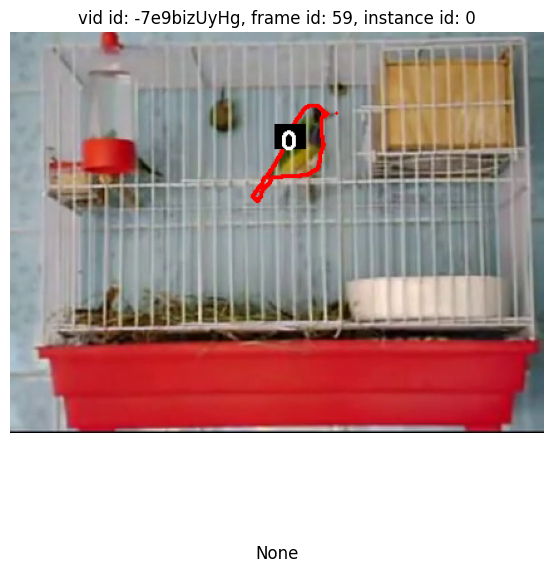

-8FLF-osZmA


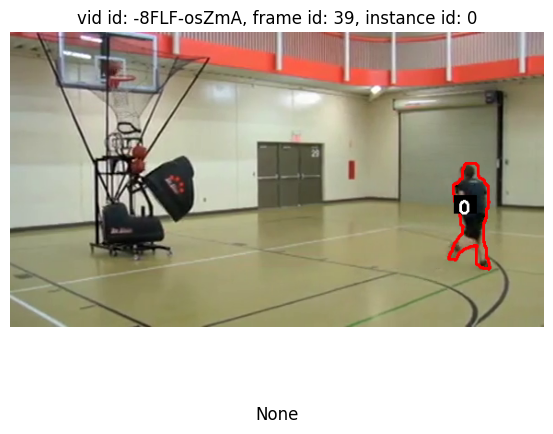

-8FLF-osZmA


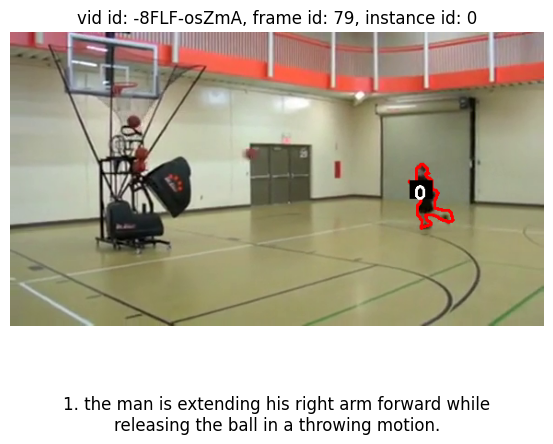

-8FLF-osZmA


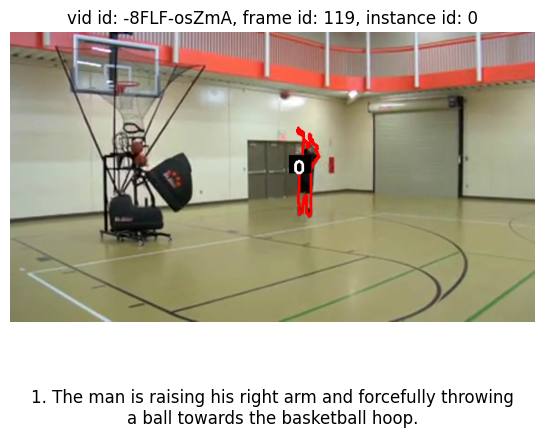

-8FLF-osZmA


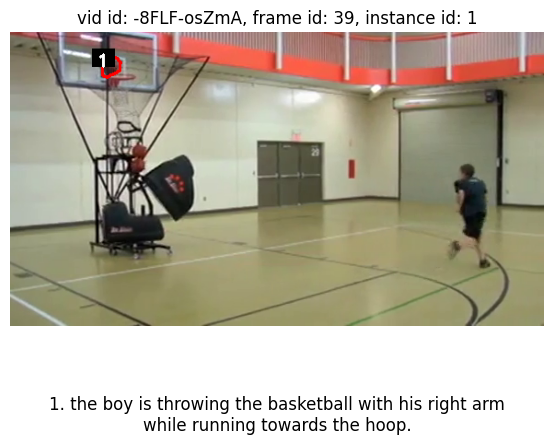

-8FLF-osZmA


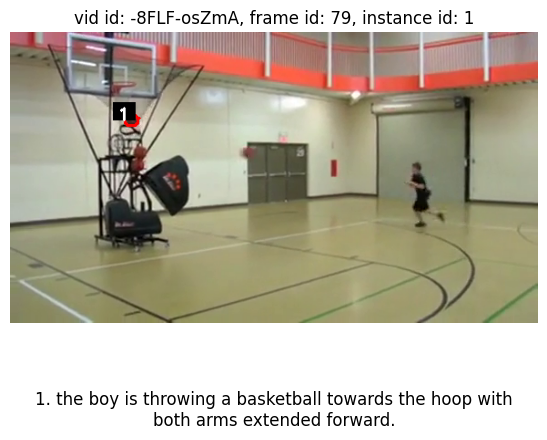

-8FLF-osZmA


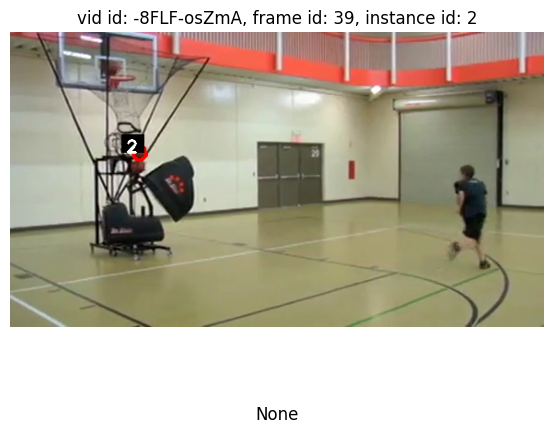

-8FLF-osZmA


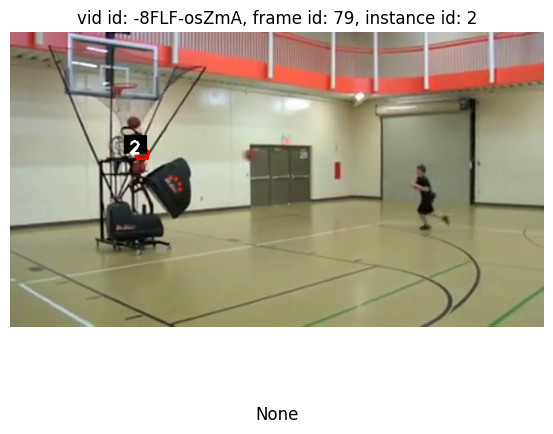

-8FLF-osZmA


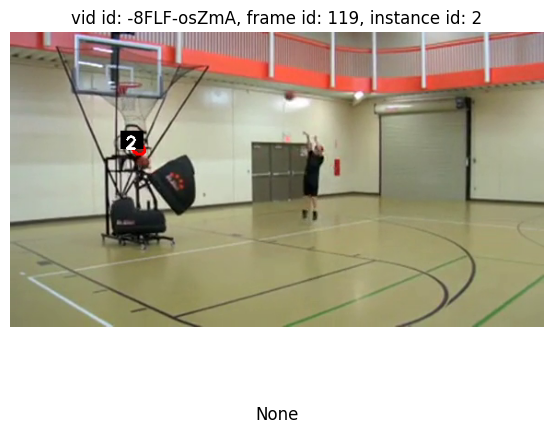

-8FLF-osZmA


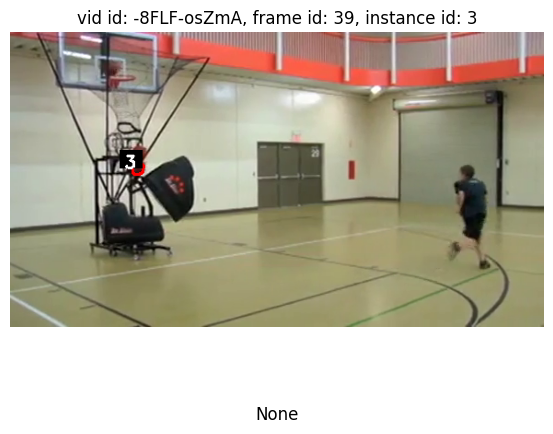

-8FLF-osZmA


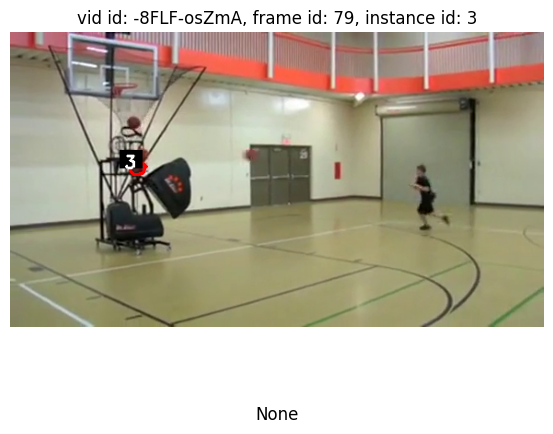

-8FLF-osZmA


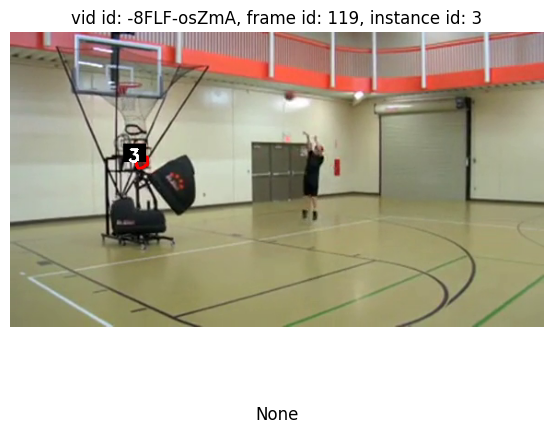

-8FLF-osZmA


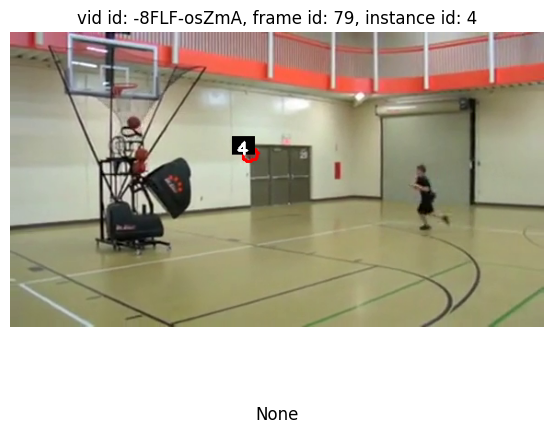

-8FLF-osZmA


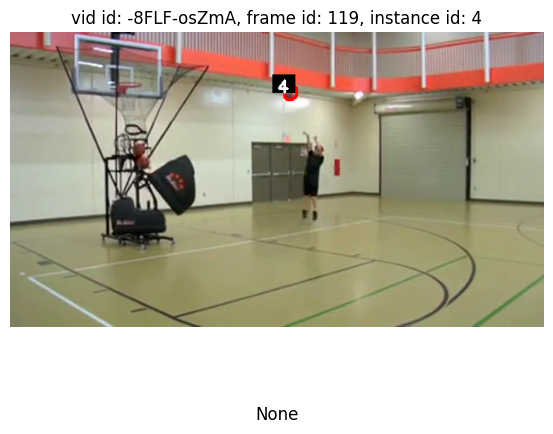

In [35]:
partial_vid_ids = list(captions.keys())[12:15]
partial_captions = {vid_id : captions[vid_id] for vid_id in partial_vid_ids}
checkAllCaptions(partial_captions, train_dataset, text_annotations)